# Preprocessing and Feature Engineering

**Imports**

In [1]:
import gc
import os
import joblib
import random
import warnings
import itertools
import scipy as sp
import numpy as np
import pandas as pd
from tqdm import tqdm
import lightgbm as lgb
from itertools import combinations
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from sklearn.preprocessing import LabelEncoder
import warnings; warnings.filterwarnings('ignore')
from sklearn.model_selection import StratifiedKFold, train_test_split

In [2]:
def get_difference(data, num_features):
    df1 = []
    customer_ids = []
    for customer_id, df in tqdm(data.groupby(['customer_ID'])):
        diff_df1 = df[num_features].diff(1).iloc[[-1]].values.astype(np.float32)
        df1.append(diff_df1)
        customer_ids.append(customer_id)
    df1 = np.concatenate(df1, axis = 0)
    df1 = pd.DataFrame(df1, columns = [col + '_diff1' for col in df[num_features].columns])
    df1['customer_ID'] = customer_ids
    return df1

In [3]:
def read_preprocess_data():
    train = pd.read_parquet('../input/amex-data-integer-dtypes-parquet-format/train.parquet')
    train.describe()
    train.plot()
    features = train.drop(['customer_ID', 'S_2'], axis = 1).columns.to_list()
    features.describe()
    features.plot()
    cat_features = [
        "B_30",
        "B_38",
        "D_114",
        "D_116",
        "D_117",
        "D_120",
        "D_126",
        "D_63",
        "D_64",
        "D_66",
        "D_68",
    ]
    num_features = [col for col in features if col not in cat_features]
    print('Starting training feature engineer...')
    train_num_agg = train.groupby("customer_ID")[num_features].agg(['first', 'mean', 'std', 'min', 'max', 'last'])
    train_num_agg.describe()
    train_num_agg.plot()
    train_num_agg.columns = ['_'.join(x) for x in train_num_agg.columns]
    train_num_agg.reset_index(inplace = True)

    # Lag Features
    for col in train_num_agg:
        if 'last' in col and col.replace('last', 'first') in train_num_agg:
            train_num_agg[col + '_lag_sub'] = train_num_agg[col] - train_num_agg[col.replace('last', 'first')]
            train_num_agg[col + '_lag_div'] = train_num_agg[col] / train_num_agg[col.replace('last', 'first')]

    train_cat_agg = train.groupby("customer_ID")[cat_features].agg(['count', 'first', 'last', 'nunique'])
    train_num_agg.describe()
    train_num_agg.plot()
    train_cat_agg.columns = ['_'.join(x) for x in train_cat_agg.columns]
    train_cat_agg.reset_index(inplace = True)
    
    train_labels = pd.read_csv('../input/amex-default-prediction/train_labels.csv')
    train_labels.describe()
    train_labels.plot()
    # Transform float64 columns to float32
    cols = list(train_num_agg.dtypes[train_num_agg.dtypes == 'float64'].index)
    for col in tqdm(cols):
        train_num_agg[col] = train_num_agg[col].astype(np.float32)
    # Transform int64 columns to int32
    cols = list(train_cat_agg.dtypes[train_cat_agg.dtypes == 'int64'].index)
    for col in tqdm(cols):
        train_cat_agg[col] = train_cat_agg[col].astype(np.int32)
    # Get the difference
    train_diff = get_difference(train, num_features)
    train = train_num_agg.merge(train_cat_agg, how = 'inner', on = 'customer_ID').merge(train_diff, how = 'inner', on = 'customer_ID').merge(train_labels, how = 'inner', on = 'customer_ID')
    train.describe()
    train.plot()
    del train_num_agg, train_cat_agg, train_diff
    gc.collect()
    
    # Test FE
    test = pd.read_parquet('../input/amex-data-integer-dtypes-parquet-format/test.parquet')
    print('Starting test feature engineer...')
    test_num_agg = test.groupby("customer_ID")[num_features].agg(['first', 'mean', 'std', 'min', 'max', 'last'])
    test_num_agg.describe()
    test_num_agg.plot()
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]
    test_num_agg.reset_index(inplace = True)

    # Lag Features
    for col in test_num_agg:
        if 'last' in col and col.replace('last', 'first') in test_num_agg:
            test_num_agg[col + '_lag_sub'] = test_num_agg[col] - test_num_agg[col.replace('last', 'first')]
            test_num_agg[col + '_lag_div'] = test_num_agg[col] / test_num_agg[col.replace('last', 'first')]

    test_cat_agg = test.groupby("customer_ID")[cat_features].agg(['count', 'first', 'last', 'nunique'])
    test_num_agg.describe()
    test_num_agg.plot()
    test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]
    test_cat_agg.reset_index(inplace = True)
    # Transform float64 columns to float32
    cols = list(test_num_agg.dtypes[test_num_agg.dtypes == 'float64'].index)
    for col in tqdm(cols):
        test_num_agg[col] = test_num_agg[col].astype(np.float32)
    # Transform int64 columns to int32
    cols = list(test_cat_agg.dtypes[test_cat_agg.dtypes == 'int64'].index)
    for col in tqdm(cols):
        test_cat_agg[col] = test_cat_agg[col].astype(np.int32)
    # Get the difference
    test_diff = get_difference(test, num_features)
    test = test_num_agg.merge(test_cat_agg, how = 'inner', on = 'customer_ID').merge(test_diff, how = 'inner', on = 'customer_ID')
    test.describe()
    test.plot()
    del test_num_agg, test_cat_agg, test_diff
    gc.collect()
    # Save files to disk

    train.to_parquet('train_fe_plus_plus.parquet')
    test.to_parquet('test_fe_plus_plus.parquet')
    
# Read & Preprocess Data
# read_preprocess_data()

# Training & Inference

In [4]:
class CFG:
    seed = 42
    n_folds = 5
    target = 'target'
    input_dir = '../input/amex-fe/'

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

def read_data():
    train = pd.read_parquet(CFG.input_dir + 'train_fe_plus_plus.parquet')
    test = pd.read_parquet(CFG.input_dir + 'test_fe_plus_plus.parquet')
    return train, test

def amex_metric(y_true, y_pred):
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:,0]==0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04012353 * np.sum(weights))]
    top_four = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])
    gini = [0,0]
    for i in [1,0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:,0]==0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] *  weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)
    return 0.5 * (gini[1]/gini[0] + top_four)

def amex_metric_np(preds, target):
    indices = np.argsort(preds)[::-1]
    preds, target = preds[indices], target[indices]
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_mask = cum_norm_weight <= 0.04
    d = np.sum(target[four_pct_mask]) / np.sum(target)
    weighted_target = target * weight
    lorentz = (weighted_target / weighted_target.sum()).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()
    n_pos = np.sum(target)
    n_neg = target.shape[0] - n_pos
    gini_max = 10 * n_neg * (n_pos + 20 * n_neg - 19) / (n_pos + 20 * n_neg)
    g = gini / gini_max
    return 0.5 * (g + d)

### Training LightGBM (DART) Model

In [5]:
def lgb_amex_metric(y_pred, y_true):
    y_true = y_true.get_label()
    return 'amex_metric', amex_metric(y_true, y_pred), True

def train_and_evaluate(train, test):
    # Label encode categorical features
    cat_features = [
        "B_30",
        "B_38",
        "D_114",
        "D_116",
        "D_117",
        "D_120",
        "D_126",
        "D_63",
        "D_64",
        "D_66",
        "D_68"
    ]
    cat_features = [f"{cf}_last" for cf in cat_features]
    for cat_col in cat_features:
        encoder = LabelEncoder()
        train[cat_col] = encoder.fit_transform(train[cat_col])
        test[cat_col] = encoder.transform(test[cat_col])
    # Round last float features to 2 decimal place
    num_cols = list(train.dtypes[(train.dtypes == 'float32') | (train.dtypes == 'float64')].index)
    num_cols = [col for col in num_cols if 'last' in col]
    for col in num_cols:
        train[col + '_round2'] = train[col].round(2)
        test[col + '_round2'] = test[col].round(2)
    # Get the difference between last and mean
    num_cols = [col for col in train.columns if 'last' in col]
    num_cols = [col[:-5] for col in num_cols if 'round' not in col]
    for col in num_cols:
        try:
            train[f'{col}_last_mean_diff'] = train[f'{col}_last'] - train[f'{col}_mean']
            test[f'{col}_last_mean_diff'] = test[f'{col}_last'] - test[f'{col}_mean']
        except:
            pass
    # Transform float64 and float32 to float16
    num_cols = list(train.dtypes[(train.dtypes == 'float32') | (train.dtypes == 'float64')].index)
    for col in tqdm(num_cols):
        train[col] = train[col].astype(np.float16)
        test[col] = test[col].astype(np.float16)
    # Get feature list
    features = [col for col in train.columns if col not in ['customer_ID', CFG.target]]
    params = {
        'objective': 'binary',
        'metric': "binary_logloss",
        'boosting': 'dart',
        'seed': CFG.seed,
        'num_leaves': 100,
        'learning_rate': 0.01,
        'feature_fraction': 0.50,
        'bagging_freq': 10,
        'bagging_fraction': 0.80,
        'n_jobs': -1,
        'lambda_l2': 2,
        'min_data_in_leaf': 40
        }
    # Create a numpy array to store test predictions
    test_predictions = np.zeros(len(test))
    # Create a numpy array to store out of folds predictions
    oof_predictions = np.zeros(len(train))
    kfold = StratifiedKFold(n_splits = CFG.n_folds, shuffle = True, random_state = CFG.seed)
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train, train[CFG.target])):
        print(' ')
        print('-'*50)
        print(f'Training fold {fold} with {len(features)} features...')
        x_train, x_val = train[features].iloc[trn_ind], train[features].iloc[val_ind]
        y_train, y_val = train[CFG.target].iloc[trn_ind], train[CFG.target].iloc[val_ind]
        lgb_train = lgb.Dataset(x_train, y_train, categorical_feature = cat_features)
        lgb_valid = lgb.Dataset(x_val, y_val, categorical_feature = cat_features)
        model = lgb.train(
            params = params,
            train_set = lgb_train,
            num_boost_round = 10500,
            valid_sets = [lgb_train, lgb_valid],
            early_stopping_rounds = 100,
            verbose_eval = 500,
            feval = lgb_amex_metric
            )
        # Save best model
        joblib.dump(model, f'lgbm_fold{fold}_seed{CFG.seed}.pkl')
        # Predict validation
        val_pred = model.predict(x_val)
        # Add to out of folds array
        oof_predictions[val_ind] = val_pred
        # Predict the test set
        test_pred = model.predict(test[features])
        test_predictions += test_pred / CFG.n_folds
        # Compute fold metric
        score = amex_metric(y_val, val_pred)
        print(f'Our fold {fold} CV score is {score}')
        del x_train, x_val, y_train, y_val, lgb_train, lgb_valid
        gc.collect()
    # Compute out of folds metric
    score = amex_metric(train[CFG.target], oof_predictions)
    print(f'Our out of folds CV score is {score}')
    # Create a dataframe to store out of folds predictions
    oof_df = pd.DataFrame({'customer_ID': train['customer_ID'], 'target': train[CFG.target], 'prediction': oof_predictions})
    oof_df.to_csv(f'oof_lgbm_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)
    # Create a dataframe to store test prediction
    test_df = pd.DataFrame({'customer_ID': test['customer_ID'], 'prediction': test_predictions})
    test_df.to_csv(f'test_lgbm_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)

# seed_everything(CFG.seed)
# train, test = read_data()
# train_and_evaluate(train, test)

# Prediction

<AxesSubplot:>

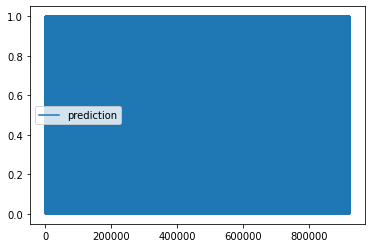

In [6]:
import os
import pandas as pd

df_1 = pd.read_csv('../input/amex-all-feats-preds/test_lgbm_v3_5fold_seed42.csv')
df_1.to_csv('submission.csv', index=False)
df_1.describe()
df_1.plot()